In [1]:
import json
import shutil
from pathlib import Path

In [2]:
import scipy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
LABELS_PATH = Path("labels.json")

In [4]:
FOURIER_COEFFS_DIR = Path("fourier_coeffs")

In [5]:
SAMPLE_SIZE = 4098

In [6]:
SAMPLING_FREQ = 12000

In [7]:
label_map = json.loads(LABELS_PATH.read_text())

In [8]:
label_map

{'CWRU-dataset-main/Normal': 0,
 'CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/IR/007': 1,
 'CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/IR/014': 2,
 'CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/IR/021': 3,
 'CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/B/007': 4,
 'CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/B/014': 5,
 'CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/B/021': 6,
 'CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/007/@3': 7,
 'CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/007/@6': 7,
 'CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/007/@12': 7,
 'CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/014': 8,
 'CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/021/@3': 9,
 'CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/021/@6': 9,
 'CWRU-dataset-main/12k_Drive_End_Bearing_Fault_Data/OR/021/@12': 9}

In [9]:
if FOURIER_COEFFS_DIR.exists():
    shutil.rmtree(FOURIER_COEFFS_DIR)

In [10]:
def sample(signal, sample_size):
    remainder = len(signal) % sample_size
    signal = signal[:-remainder]
    signal_samples = signal.reshape(-1, sample_size)
    return signal_samples

In [11]:
def transform(signal_samples):
    fourier_coeffs_samples = []

    for signal_sample in signal_samples:
        fourier_coeffs = np.abs(np.fft.fft(signal_sample))
        fourier_coeffs = fourier_coeffs[:len(fourier_coeffs) // 2]
        fourier_coeffs_samples.append(fourier_coeffs)

    return np.vstack(fourier_coeffs_samples)

In [12]:
for signal_dir, label in label_map.items():
    for signal_path in Path(signal_dir).rglob("*.mat"):
        data = scipy.io.loadmat(str(signal_path))
        signal_name = signal_path.stem
        signal_name, *_, load = signal_name.split("_")
        signal_name, *_ = signal_name.split("@")
        signal = data[f"X{int(signal_name):03}_DE_time"].squeeze()

        signal_samples = sample(signal, SAMPLE_SIZE)
        fourier_coeffs_samples = transform(signal_samples)
        labels = label * np.ones((len(signal_samples), 1))
        transformed_data = np.concatenate([fourier_coeffs_samples, labels], axis=1)
        train_data, test_data = train_test_split(transformed_data, test_size=0.3)

        for phase, transformed_data in zip(["train", "test"], [train_data, test_data]):
            fourier_coeffs_path = FOURIER_COEFFS_DIR / phase / str(label) / f"{load}.mat"

            if fourier_coeffs_path.exists():
                saved_data = scipy.io.loadmat(str(fourier_coeffs_path))["data"]
                transformed_data = np.concatenate([saved_data, transformed_data], axis=0)
                
            fourier_coeffs_path.parent.mkdir(exist_ok=True, parents=True)
            scipy.io.savemat(str(fourier_coeffs_path), {"data": transformed_data})

In [13]:
sample_path = Path("fourier_coeffs/train/1/0.mat")

In [14]:
data = scipy.io.loadmat(str(sample_path))["data"]

In [15]:
labels = data[:, -1]

In [16]:
labels.shape

(20,)

In [17]:
labels

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

In [18]:
fourier_coeffs_samples = data[:, :SAMPLE_SIZE // 2]

In [19]:
fourier_coeffs_samples.shape

(20, 2049)

In [20]:
fourier_coeffs = fourier_coeffs_samples[0]

In [21]:
fourier_freqs = np.fft.fftfreq(SAMPLE_SIZE, 1 / SAMPLING_FREQ)
fourier_freqs = fourier_freqs[:SAMPLE_SIZE // 2]

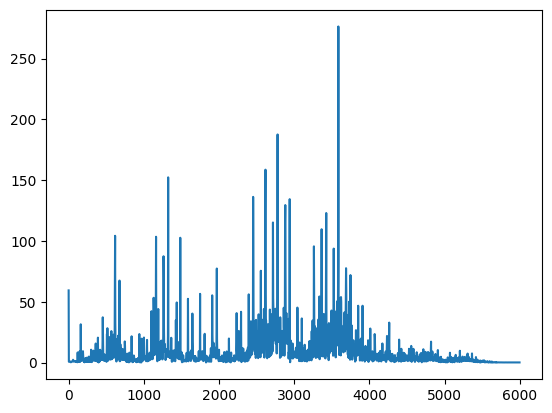

In [22]:
plt.plot(fourier_freqs, fourier_coeffs)